# Study for jitter effect in Energy resolution 

for xifusim-simulated files under different:

* Sampling rates (s1=156250, s2=s1/2, s4=s1/4)
* BBFB (yes/no)

- Libraries for test pulses reconstruction are always jitter+noise (as real pulses are)
- Curves plot (to show dependance of the energy error with arrival phase) and polynomial surfaces (to define the dependance inputEnergy <-> reconstructedEnergy <-> arrivalPhase) can be defined from noisy (5000 pulses) or nonoise (1000) pulses samples.
- It is observed that when the fitting is done with nonoise curves, the final FWHM vs. ArrivalPhase plots show estructure (are a bit curved), behaviour which is not observed when polynomial curves are created with samples of noisy pulses (no matter if the no-noise pulses are 1000 or 5000).




In [1]:
# ----IMPORT MODULES --------------
from __future__ import print_function
from __future__ import division
from multiprocessing import Pool, cpu_count
from itertools import repeat
from subprocess import check_call, check_output,STDOUT
from cycler import cycler
from astropy.io import fits
import math
import sys, os
import shutil, tempfile, shlex
import re
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error
from numpy.polynomial import Polynomial
import auxpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"


# Define auxiliary functions

In [2]:
def fit_2D_gain_scale(ph_values,phase_values,energy_list,deg=6,show=False):
    '''Fits a 2D gain scale giving the energy as a function of ph and phase (by PP)
    
    Arguments:
        - ph_values: 2D array of the measured PH values
        - phase_values: 2D array of the measured phase values
        - energy_list: 1D array of the simulated energies
        - deg: degree of the polynom to fit (in both X and Y)
        - show: option to plot the results
    '''
    ph_values = np.array(ph_values)
    phase_values = np.array(phase_values)
    energies = np.array([energy_list for _ in range(len(ph_values[0]))]).transpose()
    poly_coeffs = polyfit2d(ph_values, phase_values, energies, [deg,deg])
    return poly_coeffs

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = np.polynomial.polynomial.polyvander2d(x, y, deg)
    #print(vander.size)
    #print(vander)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

# Define variables 

In [3]:
#      Simulation options to calculate jitter correction
# ========================================================
dcmt = 100 # decimation factor - NOT USED if BBFB
bbfb = "bbfb" # "" for not_bbfb or "bbfb" for dobbfb in xifusim
smprt = "" # "" or "samprate2" or "samprate4"
npulsesLib = 20000 # number of pulses for libraries
npulsesGain = 5000 # number of pulses for gainScale
preBufferSize = 1000
Fitting35=3
noiseForSFC = "" # "" for noisy files and "_nonoise" for nonoise files 
if noiseForSFC == "_nonoise": 
    SFCpulses = 1000 # number of pulses for curve/surface creation (nonoise)
    noiseStr="NO NOISE"
if noiseForSFC == "":
    SFCpulses = 5000 # number of pulses for curve/surface creation (noisy)
    noiseStr="NOISY"
    
#TSpulses = 2000 # number of pulses for test of FWHM (noisy)
TSpulses = "2E5" # number of pulses for test of FWHM (noisy)

eurecaDir = "/dataj6/ceballos/INSTRUMEN/EURECA"
sixteDir = eurecaDir + "/testHarness/simulations/SIXTE"
sixteInst = os.environ["SIXTE"] + "/share/sixte/instruments/athena-xifu/"
xmlfile = (sixteInst +
            "/xifu_detector_lpa_75um_AR0.5_pixoffset_mux40_pitch275um.xml")
pairsDir = eurecaDir + "/ERESOL/PAIRS"
impDir = pairsDir + "/PIXIMPACT"
ereDir = pairsDir + "/eresolLPA75um"
tesDir = pairsDir + "/xifusimLPA75um"
coeffsfile = ereDir + "/coeffs_polyfit.dat"
eners_keV = (0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8)
calibEnergies = [0.2, 0.5, 1, 2, 3, 4, 5, 6, 7, 8]
libEnergies = (6,) # optimal filter in library
eners_keV = (1, 2, 3, 4, 5, 6, 7, 8)
test_keV = (1,2,3,4,5,6,7,8)
test_keV = (7,)

# samprate
smprtStr = ""
if smprt == "samprate2":
    smprtStr = "_samprate2"
    samprate = 78125. # Hz
    pulseLength = 4096
    nSamples = 4096
    largeFilter = 4096
    nSgms = 4 #6
    samplesUp = 2 #2
    samplesDown = 4 #3 
    singleSeparation = 20000
    #TSexpos=540 # for the test-noisy pulses
    #NNexpos=269 # for the nonoise pulses
elif smprt == "samprate4":
    smprtStr = "_samprate4"
    samprate = 39062.5 # Hz
    pulseLength = 2048
    nSamples = 2048
    largeFilter = 2048
    nSgms = 4 #6
    samplesUp = 2 #2
    samplesDown = 4 #3 
    singleSeparation = 10000
else:
    samprate = 156250. # Hz
    pulseLength = 8192
    nSamples = 8192
    largeFilter = 8192
    nSgms = 3.5
    samplesUp = 3
    samplesDown = 4
    singleSeparation = 40000
    #TSexpos=525 # for the test-noisy pulses
    #NNexpos=262 # for the nonoise pulses

triggerSizeTC = 1000 + 2*singleSeparation + 1000
triggerSizeTS = preBufferSize + pulseLength + 1000
triggerTS3val = triggerSizeTS - preBufferSize

# jitter
jitterStr = ""
jitterStrPix = ""
offset = 0
#bbfb
bbfbStr = ""
if bbfb == "bbfb":
    bbfbStr = "_bbfb"
    jitterStr = "_jitter"
    jitterStrPix = "_jitter"
elif dcmt > 1 :
    jitterStr = "_jitter_dcmt" + str(dcmt)
    jitterStrPix = "_jitter"
    offset = -1

# define optimized colors for offset plots
cols = [(165,0,38),(215,48,39),(244,109,67),(253,174,97),(254,224,144),(224,243,248),(171,217,233),(116,173,209),
        (69,117,180),(49,54,149)]
reversed_cols = cols[::-1]
for i in range(0,len(cols)):
        cols[i] = tuple(round((x/255.),2) for x in reversed_cols[i])
        # print("Color=", cols[i])



# ... and filenames

In [4]:
# a) Filenames for surface fitting and dependency curves 
# ========================================================
#impFs = list()
#imp0Fs = list()
evtFs = list()
calibFs = list()
tesFs = list()
libfile = (sixteDir + "/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(npulsesLib) + "p" + smprtStr + jitterStr + noiseForSFC + bbfbStr + ".fits")

for i in range(0,len(eners_keV)):
    #file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(NNexpos) + "s_" + str(eners_keV[i]) + "keV" +
    #        smprtStr + jitterStrPix + "_trSz" + str(triggerSizeTC) + ".piximpact")
    #impFs.append(file)
   
    #file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(NNexpos) + "s_" + str(eners_keV[i]) + "keV" +
    #        smprtStr + "_trSz" + str(triggerSizeTC) + ".piximpact")
    #imp0Fs.append(file)
    
    file = (tesDir + "/sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_" + str(eners_keV[i]) + "keV" +
            smprtStr + jitterStr + noiseForSFC + bbfbStr + ".fits")
    tesFs.append(file)
    
    file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(eners_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + noiseForSFC + bbfbStr + "_FT" + str(Fitting35) + ".fits")
    evtFs.append(file)

    file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(SFCpulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(eners_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + noiseForSFC + bbfbStr + "_FT" + str(Fitting35) + ".calib")
    calibFs.append(file)

# a) Filenames for test (noisy)
# =============================
#test_impFs = list()
test_tesFs = list()
test_evtFs = list()
test_calibFs = list()
tnpulsesLib = 20000
    
tlibfile = (sixteDir + "/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL" + str(pulseLength) + "_" +
           str(tnpulsesLib) + "p" + smprtStr + jitterStr + bbfbStr + ".fits")

for i in range(len(test_keV)):
    #file = (impDir + "/sep" + str(singleSeparation) + "sam_" + str(TSexpos) + "s_" + str(test_keV[i]) + "keV" +
    #        smprtStr + jitterStrPix + "_trSz" + str(triggerSizeTC) + ".piximpact")
    #test_impFs.append(file)
    file = (tesDir + "/sep" + str(singleSeparation) + "sam_" + str(TSpulses) + "p_" + str(test_keV[i]) + "keV" +
            smprtStr + jitterStr + bbfbStr + ".fits")
    test_tesFs.append(file)
    file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(TSpulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(test_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + bbfbStr + "_FT" + str(Fitting35) + ".fits")
    test_evtFs.append(file)
    file = (ereDir + "/events_sep" + str(singleSeparation) + "sam_" + str(TSpulses) + "p_SIRENA" + str(pulseLength)+ "_pL" +
            str(pulseLength) + "_" + str(test_keV[i]) + "keV_STC_F0F_fixedlib6OF_OPTFILT" + 
            str(pulseLength) + smprtStr + jitterStr + bbfbStr + "_FT" + str(Fitting35) + ".calib")
    test_calibFs.append(file)



# Data files for surface fitting (NOISE or NONOISE) - those from gainscale

PIXIMPACT -> XIFUSIM (serpens)-> SIRENA(STC) -> CALIBRATED


In [5]:
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Reconstructing SURFACE",SFCpulses, "single files with lib:", libfile)
    print("jitter=",jitterStr,"bbfb=",bbfb,"samprate=",smprtStr)
    #sys.exit()
    for i in range(0,len(eners_keV)):
        comm = ("tesreconstruction Recordfile=" + tesFs[i] + " TesEventFile=" + evtFs[i] + " Rcmethod=SIRENA" + 
                " PulseLength="+ str(pulseLength) + " LibraryFile=" + libfile +
                " samplesUp=" + str(samplesUp) + " nSgms=" + str(nSgms) + " samplesDown=" + str(samplesDown) + 
                " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC Fitting35=" + str(Fitting35) +
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1" + 
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength))
        try:
            print("Reconstructing: ", tesFs[i])
            print(comm)
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for SIRENA reconstruction with command:\n", comm)
            shutil.rmtree(tmpDir)
            raise
    print("########################")        
    print("SIRENA files created")            
    print("########################")        
#sys.exit()

In [7]:
run = 1
# 4) Correct energies from gain scale
if run: 
    print("Correcting SURFACE",SFCpulses, "pulses single files with lib:", libfile)
    print("jitter=",jitterStr,"bbfb=",bbfb,"samprate=",smprtStr)
    for i in range(0,len(eners_keV)):
        alias = "STC_F0F_fixedlib6OF_OPTFILT" + str(pulseLength) + smprtStr + jitterStr + noiseForSFC + bbfbStr
        print("alias=", alias)
        comm = ("python calibEnergies.py --inFile=" + evtFs[i] + " --outFile=" + calibFs[i] + 
                " --coeffsFile=" + coeffsfile + " --alias=" + alias)
        try:
            print("Calibrating: ", evtFs[i])
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for GAIN SCALE calibration with comm=")
            print(comm)
            shutil.rmtree(tmpDir)
            raise

    print("########################")        
    print("CALIBRATED files created")            
    print("########################")        
#sys.exit()

Correcting SURFACE 5000 pulses single files with lib: /dataj6/ceballos/INSTRUMEN/EURECA/testHarness/simulations/SIXTE/LIBRARIES/xifusimLPA75um/GLOBAL/ADC/library6keV_PL4096_20000p_samprate2_jitter_nonoise_bbfb.fits
jitter= _jitter bbfb= bbfb samprate= _samprate2
alias= STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb
Calibrating:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_1keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
alias= STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb
Calibrating:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_2keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
alias= STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb
Calibrating:  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_3keV_STC_F0F_fixedlib6OF

# Test Files (noisy): piximpact, xifusim (serpens), uncalE, calE

In [ ]:
run = 0
# 3) Run SIRENA (AD,STC)
# =======================
if run:
    print("Creating SIRENA test files for BBFB=",bbfb,"SAMPRATE=",smprt,"and libfile=", tlibfile)
    for i in range(0,len(test_keV)):
        comm = ("tesreconstruction Recordfile=" + test_tesFs[i] + " TesEventFile=" + test_evtFs[i] +
                " Rcmethod=SIRENA" + " PulseLength=" + str(pulseLength) + " LibraryFile=" + tlibfile +
                " samplesUp=" + str(samplesUp) + " nSgms=" + str(nSgms) + " samplesDown=" + str(samplesDown) + 
                " opmode=1 OFLib=yes FilterDomain=F detectionMode=STC Fitting35=" + str(Fitting35) +
                " FilterMethod=F0 clobber=yes EventListSize=1000 EnergyMethod=OPTFILT LagsOrNot=1" +
                " XMLFile=" + xmlfile + " filtEeV=6000.0 OFStrategy=FIXED OFLength=" + str(pulseLength))
        try:
            print(comm)
            print("Reconstructing: ", test_tesFs[i])
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except RuntimeError:
            print("Error running tool for SIRENA reconstruction with command:")
            print(comm)
            raise
    print("########################")        
    print("test SIRENA files created")            
    print("########################")   

In [ ]:
run=0
if run:
    print("Creating CALIB test files for BBFB,SAMPRATE=",bbfb,smprt)
    # 4) Correct energies from gain scale
    # =======================
    for i in range(0,len(test_keV)):
        alias = "STC_F0F_fixedlib6OF_OPTFILT" + str(pulseLength) + smprtStr + jitterStr + bbfbStr
        comm = ("python calibEnergies.py --inFile=" + test_evtFs[i] + " --outFile=" + test_calibFs[i] + 
                " --coeffsFile=" + coeffsfile + " --alias=" + alias)
        try:
            print("Running comm=", comm)
            print("Calibrating: ", test_evtFs[i])
            args = shlex.split(comm)
            check_call(args, stderr=STDOUT)
        except:
            print("Error running tool for GAIN SCALE calibration")
            shutil.rmtree(tmpDir)
            raise
    print("##################################")
    print("TEST Files created and calibrated")
    print("##################################")

#  Reconstructed Energy vs Arrival Phase (NOISE or NONOISE)

## a) Plot curves

Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_1keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_2keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_3keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_4keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
Opening file  /dataj6/ceballos/INSTRUMEN/EURECA/ERESOL/PAIRS/eresolLPA75um/events_sep20000sam_5000p_SIRENA4096_pL4096_5keV_STC_F0F_fixedlib6OF_OPTFILT4096_samprate2_jitter_nonoise_bbfb_FT3.fits
Opening file  /dataj6/ceballos

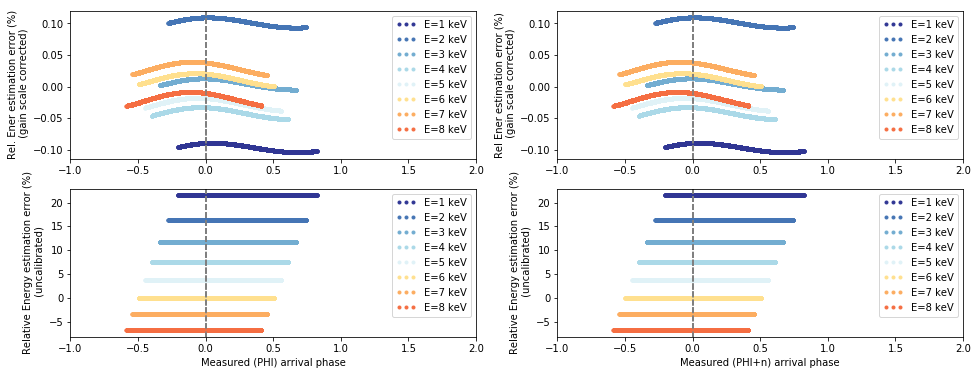

In [8]:
# Find number of pulses (after cleaning of xifusim files)
npls = list()

for i in range(0,len(eners_keV)):
    print ("Opening file ",evtFs[i])
    uncal = fits.open(evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    npls.append(uncalTab.size)
    uncal.close()
nCpulses = np.amin(npls)
print("Plotting curves for nCpulses=",nCpulses, "samprate=",samprate, bbfb)

ph_values = np.zeros((len(eners_keV),nCpulses))
phcorr_values = np.zeros((len(eners_keV),nCpulses))
#Phase0_values = np.zeros((len(eners_keV),nCpulses))
PHI_values = np.zeros((len(eners_keV),nCpulses))
PHIn_values = np.zeros((len(eners_keV),nCpulses))

for i in range(0,len(eners_keV)):
    # Impacts
    #imp = fits.open(impFs[i], memmap=True)
    #impTab = imp[1].data
    #impTimes = impTab['TIME']
    #impIDs = impTab['PH_ID']
    #imp.close()
    
    # Detected events
    uncal = fits.open(evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    uncalTimes = uncalTab['TIME']
    uncalEners = uncalTab['SIGNAL']
    uncalPHIS = uncalTab['PHI']
    uncalLAGS = uncalTab['LAGS']
    ph_values[i,] = uncalEners[0:nCpulses]
    PHI_values[i,] = uncalPHIS[0:nCpulses]
    PHIn_values[i,] = uncalPHIS[0:nCpulses] + uncalLAGS[0:nCpulses] 
    uncal.close()
    
    # Calibrated events (gain-scale corrected)
    cal = fits.open(calibFs[i], memmap=True)
    calTab = cal[1].data
    calTimes = calTab['TIME']
    calEners = calTab['SIGNAL']
    phcorr_values[i,] = calEners[0:nCpulses]
    cal.close()

    # look for energy string in name to get simulated energy
    srch = re.search('(?<=_)[0.]*[1-9](?=keV_STC)', calibFs[i])
    inkeV = float(srch.group(0))
    
    if inkeV != eners_keV[i]:
        print("Error: incompatible energies in input files:",inkeV,eners_keV[i])
        sys.exit()
    
    # energy errors
    relErr = (calEners - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    relErrUncal = (uncalEners - inkeV)*100./inkeV  # [%] Relative uncalEnergy Estimation Error
    
    # simulated phase
    #if (samprate == ""):
    #    arrPhase0 = auxpy.arrivalPhase(impF=impFs[i], evtF=evtFs[i],samprate=samprate, arrmethod=0)
    #    Phase0_values[i,] = arrPhase0[0:nCpulses]
    
    # phase from trigger-sample (<=1) 
    # arrPhasePHI = auxpy.arrivalPhase(impF=impFs[i], evtF=evtFs[i],samprate=samprate, arrmethod=6)
    # phase from trigger-sample 
    # arrPhasePHIn = auxpy.arrivalPhase(impF=impFs[i], evtF=evtFs[i],samprate=samprate, arrmethod=5)
    
    #PHI_values[i,] = arrPhasePHI[0:nCpulses]
    #PHIn_values[i,] = arrPhasePHIn[0:nCpulses]
        
fig = plt.figure(figsize=(16,6))

# Plot RelativeErrCorrEner vs Simulated Phases
#=============================================
#ax = fig.add_subplot(231)
#ax.set_ylabel("Rel. Ener estimation error (%)\n (gain scale corrected)")
#for i in range(len(eners_keV)):
#    inkeV = eners_keV[i]
#    relErr = (phcorr_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
#    labelLeg = "E=" + str(inkeV) + " keV"
#    fc = cols[i]
#    #if i % 2 == 0:
#        #fc = 'none'
#    ax.plot(Phase0_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
#             markeredgecolor=cols[i], label=labelLeg, ms=3)
#    ax.set_xlim(-1,2)
#    ax.axvline(x=0, linestyle="dashed",color="gray")
#    ax.legend(numpoints=3)
    
# Plot RelativeErrCorrEner vs PHI measured Phases
# =================================================
#ax = fig.add_subplot(232)
ax = fig.add_subplot(221)
ax.set_ylabel("Rel. Ener estimation error (%)\n (gain scale corrected)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (phcorr_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    #if i % 2 == 0:
    #    fc = 'none'
    ax.plot(PHI_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1.,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)
    
# Plot RelativeErrCorrEner vs Measured (PHI+n) Phases
# =================================================
#ax = fig.add_subplot(233)
ax = fig.add_subplot(222)
ax.set_ylabel("Rel Ener estimation error (%)\n (gain scale corrected)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (phcorr_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    #if i % 2 == 0:
    #    fc = 'none'
    ax.plot(PHIn_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)

    minErr = min(relErr)
    maxErr = max(relErr)
    #print("E,minErr,maxErr, Diff=", eners_keV[i], minErr, maxErr, abs(maxErr-minErr))
    
# Plot RelativeErrUncorrEner vs Simulated Phases
# =================================================
#ax = fig.add_subplot(234)
#ax.set_xlabel("Simulated arrival phase")
#ax.set_ylabel("Relative Energy estimation error (%)\n (uncalibrated)")
#for i in range(len(eners_keV)):
#    inkeV = eners_keV[i]
#    relErr = (ph_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
#    labelLeg = "E=" + str(inkeV) + " keV"
#    fc = cols[i]
#    #if i % 2 == 0:
#    #    fc = 'none'
#    ax.plot(Phase0_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
#             markeredgecolor=cols[i], label=labelLeg, ms=3)
#    ax.set_xlim(-1,2)
#    ax.axvline(x=0, linestyle="dashed",color="gray")
#    ax.legend(numpoints=3)

# Plot RelativeErrUncorrEner vs Measured (PHI) Phases
# ====================================================
#ax = fig.add_subplot(235)
ax = fig.add_subplot(223)
ax.set_xlabel("Measured (PHI) arrival phase")
ax.set_ylabel("Relative Energy estimation error (%)\n (uncalibrated)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (ph_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    #if i % 2 == 0:
    #    fc = 'none'
    ax.plot(PHI_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)

# Plot RelativeErrUnCorrEner vs measures (PHI+n) phases
# =================================================
#ax = fig.add_subplot(236)
ax = fig.add_subplot(224)
ax.set_xlabel("Measured (PHI+n) arrival phase")
ax.set_ylabel("Relative Energy estimation error (%)\n (uncalibrated)")
for i in range(len(eners_keV)):
    inkeV = eners_keV[i]
    relErr = (ph_values[i,] - inkeV)*100./inkeV  # [%] Relative Energy Estimation Error
    labelLeg = "E=" + str(inkeV) + " keV"
    fc = cols[i]
    #if i % 2 == 0:
    #    fc = 'none'
    ax.plot(PHIn_values[i,], relErr, marker='o', markerfacecolor=fc, linestyle='none', 
             markeredgecolor=cols[i], label=labelLeg, ms=3)
    ax.set_xlim(-1,2)
    ax.axvline(x=0, linestyle="dashed",color="gray")
    ax.legend(numpoints=3)

    

##  b) Plot 3D surfaces 

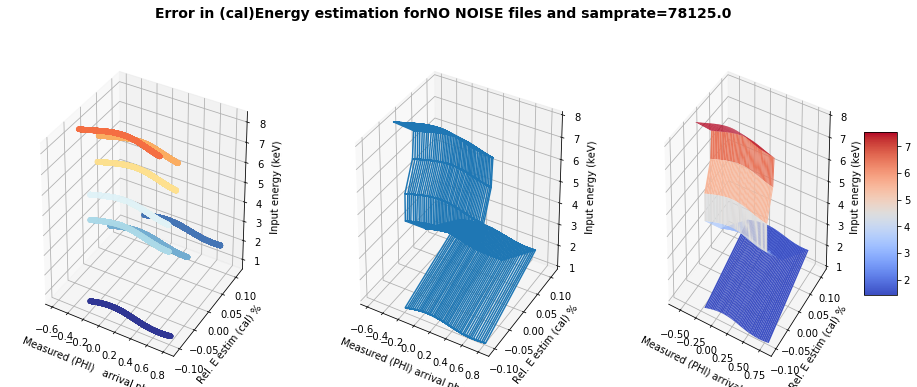

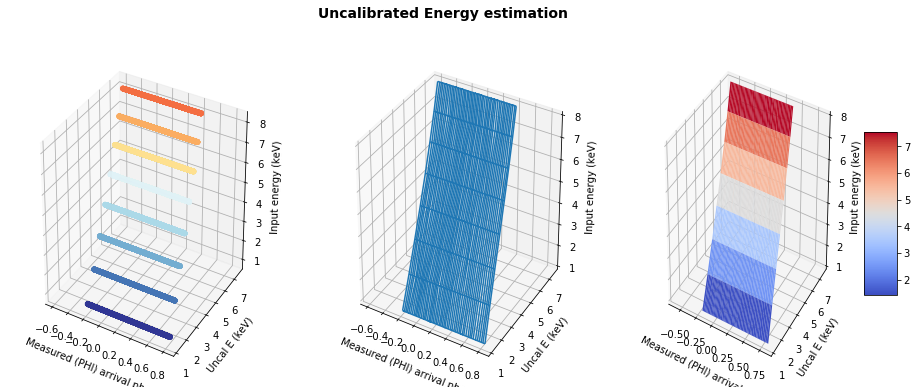

In [9]:
npts = len(PHI_values[1,])
X = np.zeros((len(eners_keV), npts))
Y = np.zeros((len(eners_keV), npts))
YS = np.zeros((len(eners_keV), npts))
Z = np.zeros((len(eners_keV), npts))

# PLOT      EcalibError  vs. offset  vs. Einput
# ==============================================
fig = plt.figure(figsize=(16,6))
suptitle='Error in (cal)Energy estimation for' + noiseStr + ' files and samprate=' + str(samprate)
fig.suptitle(suptitle, fontsize=14, fontweight='bold')

ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('Measured (PHI)   arrival phases')
ax.set_ylabel('Rel. E estim (cal) %')
ax.set_zlabel('Input energy (keV)')
for i in range(0,len(eners_keV)):
    X[i,] = PHI_values[i,]
    Y[i,] = (phcorr_values[i,]-eners_keV[i])*100./eners_keV[i]
    Z[i,] = np.repeat(eners_keV[i], npts)
    #XS[i,] = np.sort(X[i,],0)
    YS[i,] = [x for _,x in sorted(zip(X[i,],Y[i,]))]
    ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
XS = np.sort(X,1)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
ax2.set_xlabel('Measured (PHI) arrival phases')
ax2.set_ylabel('Rel. E estim (cal) %')
ax2.set_zlabel('Input energy (keV)')

ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
ax3.set_xlabel('Measured (PHI) arrival phases')
ax3.set_ylabel('Rel. E estim (cal) %')
ax3.set_zlabel('Input energy (keV)')
fig.colorbar(surf, shrink=0.5, aspect=5)

# PLOT      Euncalib  vs. offset  vs. Einput
# ===============================================
fig = plt.figure(figsize=(16,6))
fig.suptitle('Uncalibrated Energy estimation', fontsize=14, fontweight='bold')

ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('Measured (PHI) arrival phases')
ax.set_ylabel('Uncal E (keV)')
ax.set_zlabel('Input energy (keV)')
for i in range(0,len(eners_keV)):
    Y[i,] = ph_values[i,]
    YS[i,] = [x for _,x in sorted(zip(X[i,],Y[i,]))]
    ax.scatter(xs=X[i,], ys=Y[i,], zs=eners_keV[i], zdir='z', s=20, c=cols[i], depthshade=True)
XS = np.sort(X,1)

ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_wireframe(X=XS, Y=YS, Z=Z)
ax2.set_xlabel('Measured (PHI) arrival phases')
ax2.set_ylabel('Uncal E (keV)')
ax2.set_zlabel('Input energy (keV)')

ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X=XS, Y=YS, Z=Z, cmap=cm.coolwarm, antialiased=True)
ax3.set_xlabel('Measured (PHI) arrival phases')
ax3.set_ylabel('Uncal E (keV)')
ax3.set_zlabel('Input energy (keV)')
fig.colorbar(surf, shrink=0.5, aspect=5)



# Fitting of a 2D polynomial to Unrecons vs Offsets

Based on PP functions. Functions input:

* Uncorr energies (ph_values): energies are reconstructed with a 2000p library (jitter)

* UnCorrected Arrival Phases (phase_values)

* Calibration Energies (energy_list)

In [10]:
print("Test of fitting")
coeffs=fit_2D_gain_scale(ph_values, PHI_values, eners_keV, deg=6, show=True)
print("Einput       ph(i)     PHI_val(i)   ph_corr(calib)(i)  ph_corr(poly)")
corrE = np.polynomial.polynomial.polyval2d(ph_values[1,1],PHI_values[1,1],coeffs)
print(eners_keV[1],"    ", ph_values[1,1], PHI_values[1,1], " ", phcorr_values[1,1], " ", corrE)
corrE = np.polynomial.polynomial.polyval2d(ph_values[2,1],PHI_values[2,1],coeffs)
print(eners_keV[2],"    ", ph_values[2,1], PHI_values[2,1], " ", phcorr_values[2,1], " ", corrE)


Test of fitting
Einput       ph(i)     PHI_val(i)   ph_corr(calib)(i)  ph_corr(poly)
2      2.3265417794358125 0.33705576326372333   2.002027068831394   1.9999996954026749
3      3.3521188419415275 0.09335201351716027   3.0003494193719185   3.0000018001090814


/home/ceballos/sw/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


# Test files energy corrections

Compare resconstructed energies @ 1keV and 7 keV before and after corrections.
For this, we use *TSpulses* reconstructed with a *jitter_noisy* library using the coefficients calculated below.

Correcting energies for  2E5 pulses with bbfb= bbfb and samprate= 78125.0
rms= 0.0009404157936245472


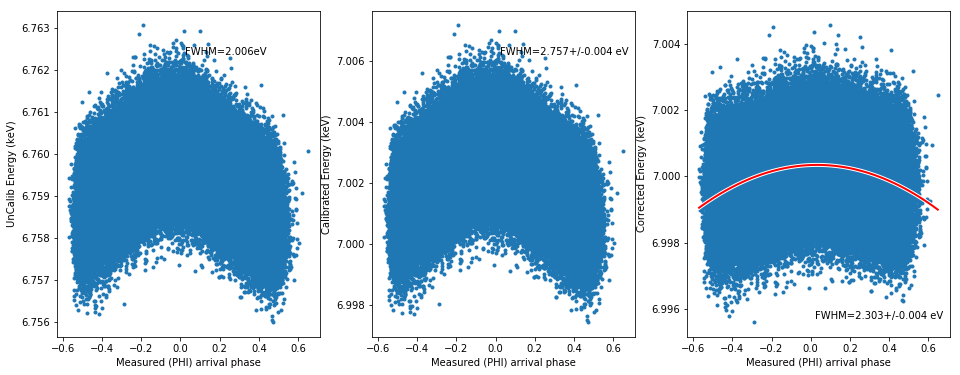

In [11]:
print("Correcting energies for ", TSpulses, "pulses with bbfb=", bbfb, "and samprate=",samprate)

#fig = plt.figure(figsize=(16,40))
fig = plt.figure(figsize=(16,6))
irws = len(test_keV)
for i in range(0,len(test_keV)):
    # Detected uncal events
    uncal = fits.open(test_evtFs[i], memmap=True)
    uncalTab = uncal[1].data
    uncalEners = uncalTab['SIGNAL']
    arrPhase = uncalTab['PHI']
    uncal.close()
    
    # Detected cal events
    cal = fits.open(test_calibFs[i], memmap=True)
    calTab = cal[1].data
    calEners = calTab['SIGNAL']
    cal.close()
    
    # Arrival Phases & Corrected energies
    #arrPhase = auxpy.arrivalPhase(impF=test_impFs[i], evtF=test_evtFs[i],samprate=samprate, arrmethod=6)
            
    relErr = (uncalEners - test_keV[i])*100./test_keV[i]
    fwhmUnCal = 'FWHM={0:0.3f}eV'.format(2.35*np.std(uncalEners)*1000) # eV
    fwhmCal = 2.35*np.std(calEners)*1000 # eV
    fwhmCal_err = fwhmCal/np.sqrt(2*float(TSpulses)-2) # eV
    fwhmCalStr = 'FWHM={:0.3f}+/-{:0.3f} eV'.format(fwhmCal, fwhmCal_err) # eV
    
    corrE = np.polynomial.polynomial.polyval2d(uncalEners, arrPhase,coeffs)
    
    #print("test_EkeV=",test_keV[i])
    #print("uncalEners[1]=",uncalEners[1])
    #print("calEners[1]=",calEners[1])
    #print("corrE[1]=",corrE[1])
    
    fwhmCorr = 2.35*np.std(corrE)*1000. # eV
    fwhmCorr_err = fwhmCorr/np.sqrt(2*float(TSpulses)-2)
    fwhmCorrStr = 'FWHM={:0.3f}+/-{:0.3f} eV'.format(fwhmCorr, fwhmCorr_err) # eV
    
    # Plot Corr UnCalE vs ArrPhse "331"
    # ============================
    figstr = str(irws)+"3"+str(3*i+1)
    ax=plt.subplot2grid((irws,3),(i,0))
    ax.set_xlabel("Measured (PHI) arrival phase")
    ax.set_ylabel("UnCalib Energy (keV)")
    ax.plot(arrPhase, uncalEners, marker='o', linestyle='none', ms=3)
    #arrPhaseMid = (np.max(arrPhase)-abs(np.min(arrPhase)))/2.
    arrPhaseMid = (max(arrPhase)-abs(min(arrPhase)))/2.
    xl = 0.55 * arrPhaseMid # xpos for label for FWHM annotation
    yl = np.min(uncalEners) + 0.9 * (np.max(uncalEners)-np.min(uncalEners))
    ax.annotate(fwhmUnCal, xy=(xl,yl))
    
    # Plot Corr CalE vs ArrPhse "332"
    # ============================
    figstr = str(irws)+"3"+str(3*i+2)
    ax=plt.subplot2grid((irws,3),(i,1))
    ax.set_xlabel("Measured (PHI) arrival phase")
    ylabel="Calibrated Energy (keV)"
    ax.set_ylabel(ylabel)
    ax.plot(arrPhase, calEners, marker='o', linestyle='none', ms=3)
    yl = np.min(calEners) + 0.9 * (np.max(calEners)-np.min(calEners))
    ax.annotate(fwhmCalStr, xy=(xl,yl))
    
    # Plot Corr CorrE vs ArrPhse "333"
    # ============================
    figstr = str(irws)+"3"+str(3*i+3)
    ax=plt.subplot2grid((irws,3),(i,2))
    ax.set_xlabel("Measured (PHI) arrival phase")
    ax.set_ylabel("Corrected Energy (keV)")
    yl = np.min(corrE) + 0.01 * (np.max(corrE)-np.min(corrE))
    ax.annotate(fwhmCorrStr, xy=(xl,yl))
    
    # plot initial polynomial fit
    #-----------------------------
    fpol = Polynomial.fit(arrPhase,corrE,2)
    #corrEcorr = test_keV[i]+corrE-fpol(arrPhase)
    #ax.plot(arrPhase, corrEcorr, marker='o', linestyle='none', ms=3)
    ax.plot(arrPhase, corrE, marker='o', linestyle='none', ms=3)
    xs = np.linspace(np.min(arrPhase),np.max(arrPhase),50)
    ax.plot(xs,fpol(xs), linestyle='-', color='white', linewidth=4)
    ax.plot(xs,fpol(xs), linestyle='-', color='red', linewidth=2)
    rms = np.sqrt(mean_squared_error(corrE,fpol(arrPhase)))
    if test_keV[i] == 7:
        print("rms=",rms)
        corrE7=corrE
        fpol7=fpol
        fwhmCorrStr7 = fwhmCorrStr
    
    # plot secondary polynomial fit
    #fpol2 = Polynomial.fit(arrPhase,corrEcorr,2)
    #ax.plot(xs,fpol2(xs), linestyle='-', color='white', linewidth=4)
    #ax.plot(xs,fpol2(xs), linestyle='-', color='green', linewidth=2)
    #fwhmCorr2 = 2.35*np.std(corrEcorr)*1000. # eV
    #fwhmCorr2_err = fwhmCorr2/np.sqrt(2*-2)
    #fwhmCorr2Str = 'FWHM={:0.2f}+/-{:0.3f} eV'.format(fwhmCorr2, fwhmCorr2_err) # eV
    #xl2 = np.min(arrPhase)
    #ax.annotate(fwhmCorr2Str, xy=(xl2,yl), color="green")

#fileplot = "EreconBBFB" + smprt + "FT" + str(Fitting35) + "_" + str(SFCpulses) + "p.png"
#fig.savefig(fileplot)    
    


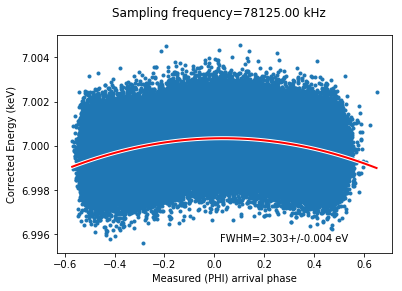

In [12]:
# Plot alone 7 keV figure
fig2 = plt.figure()
suptitle = 'Sampling frequency={:0.2f} kHz'.format(samprate)
fig2.suptitle(suptitle)
ax2 = fig2.add_subplot("111")
ax2.set_xlabel("Measured (PHI) arrival phase")
ax2.set_ylabel("Corrected Energy (keV)")
yl = np.min(corrE7) + 0.01 * (np.max(corrE7)-np.min(corrE7))
ax2.annotate(fwhmCorrStr7, xy=(xl,yl))
ax2.plot(arrPhase, corrE7, marker='o', linestyle='none', ms=3)
ax2.plot(xs,fpol7(xs), linestyle='-', color='white', linewidth=4)
ax2.plot(xs,fpol7(xs), linestyle='-', color='red', linewidth=2)
fileplot2 = ("EreconBBFB" + smprtStr + "_FT" + str(Fitting35) + "_" + str(SFCpulses) + "p" + noiseForSFC + "_" +
            str(TSpulses) + "p_7keV.png")
fig2.savefig(fileplot2)


In [ ]:
# LPA75um
# SMPRT=156250 Hz (2000p)  PolyCorr with nonoise surface
fwhmNN_smprt = (1.890,1.960,2.000,2.030,2.110,2.150,2.230,2.350)
errNN_smprt  = (0.030,0.031,0.032,0.032,0.033,0.034,0.035,0.037)
# SMPRT=156250 Hz (2000p)  PolyCorr with noisy surface
fwhm_smprt = (1.890,1.960,2.000,2.040,2.110,2.150,2.230,2.340)
err_smprt  = (0.030,0.031,0.032,0.032,0.033,0.034,0.035,0.037)
# SMPRT=156250 Hz (2000p)  CalibCorr
fwhmCal_smprt = (1.900,1.960,2.000,2.030,2.120,2.160,2.240,2.360)
errCal_smprt  = (0.030,0.031,0.032,0.032,0.033,0.034,0.035,0.037)


# SMPRT=78125 Hz  (2000p) PolyCorr with nonoise surface
fwhmNN_smprt2 = (1.880,1.980,1.950,2.000,2.130,2.190,2.270,2.460)
errNN_smprt2  = (0.030,0.031,0.031,0.032,0.034,0.035,0.036,0.039)
# SMPRT=78125 Hz  (2000p) PolyCorr with noisy surface
fwhm_smprt2 = (1.880,1.970,1.950,1.980,2.090,2.130,2.170,2.320)
err_smprt2  = (0.030,0.031,0.031,0.031,0.033,0.034,0.034,0.037)
# SMPRT=78125 Hz  (2000p) CalibCorr
fwhmCal_smprt2 = (1.900,2.000,2.010,2.120,2.350,2.510,2.710,3.030)
errCal_smprt2  = (0.030,0.032,0.032,0.034,0.037,0.040,0.043,0.048)

# SMPRT=39.0625 Hz  (2000p) PolyCorr with nonoise surface
fwhmNN_smprt4 = (1.960,2.120,2.350,2.670,3.120,3.620,4.290,5.070)
errNN_smprt4  = (0.031,0.034,0.037,0.042,0.049,0.057,0.068,0.080)
# SMPRT=39062.5 Hz  (2000p) PolyCorr with noisy surface
fwhm_smprt4 = (1.900,1.960,2.000,2.120,2.110,2.170,2.210,2.310)
err_smprt4  = (0.030,0.031,0.032,0.033,0.033,0.034,0.035,0.037)
# SMPRT=39062.5 Hz  (2000p) CalibCorr
fwhmCal_smprt4 = (2.140,2.780,3.890,5.170,6.640,8.270,10.350,12.630)
errCal_smprt4  = (0.034,0.044,0.081,0.082,0.105,0.131,0.164,0.200)


plt.errorbar(test_keV,fwhmNN_smprt,yerr=errNN_smprt,linestyle='none',fmt='s',color='blue',
             markerfacecolor='none',label='SR, polyCorr, NN surface')
plt.errorbar(test_keV,fwhm_smprt,yerr=err_smprt,linestyle='dashed',fmt='o',color='blue',
             label='SR, polyCorr, N surface')
plt.errorbar(test_keV,fwhmCal_smprt,yerr=errCal_smprt,linestyle='none',fmt='x',color='blue',
             label='SR, calibCorr')

plt.errorbar(test_keV,fwhmNN_smprt2,yerr=errNN_smprt2,linestyle='none',fmt='s',color='red',
             markerfacecolor='none',label='SR2, polyCorr, NN surface')
plt.errorbar(test_keV,fwhm_smprt2,yerr=err_smprt2,linestyle='dashed',fmt='o',color='red',
             label='SR2, polyCorr, N surface')
plt.errorbar(test_keV,fwhmCal_smprt2,yerr=errCal_smprt2,linestyle='none',fmt='x',color='red',
             label='SR2,calibCorr')

plt.errorbar(test_keV,fwhmNN_smprt4,yerr=errNN_smprt4,linestyle='none',fmt='s',color='green',
             markerfacecolor='none',label='SR4, polyCorr, NN surface')
plt.errorbar(test_keV,fwhm_smprt4,yerr=err_smprt4,linestyle='dashed',fmt='o',color='green',
             label='SR4, polyCorr, N surface')
plt.errorbar(test_keV,fwhmCal_smprt4,yerr=errCal_smprt4,linestyle='none',fmt='x',color='green',
             label='SR4,calibCorr')
plt.axhline(y=5.1, color='black', linestyle='--')
plt.legend()
plt.ylabel('FWHM (eV)')
plt.xlabel('Energy (keV)')
plt.title("Energy resolution for BBFB\n SR=156.25kHz, SR2=78.125kHz, SR4=39.0625kHz")
plt.show()

################################

plt.errorbar(test_keV,fwhmNN_smprt,yerr=errNN_smprt,linestyle='none',fmt='s',color='blue',
             markerfacecolor='none',label='SR, polyCorr NN surface')
plt.errorbar(test_keV,fwhm_smprt,yerr=err_smprt,linestyle='dashed',fmt='o',color='blue',
             label='SR, polyCorr N surface')

plt.errorbar(test_keV,fwhmNN_smprt2,yerr=errNN_smprt2,linestyle='none',fmt='s',color='red',
             markerfacecolor='none',label='SR2, polyCorr NN surface')
plt.errorbar(test_keV,fwhm_smprt2,yerr=err_smprt2,linestyle='dashed',fmt='o',color='red',
             label='SR2, polyCorr N surface')

plt.errorbar(test_keV,fwhmNN_smprt4,yerr=errNN_smprt4,linestyle='none',fmt='s',color='green',
             markerfacecolor='none',label='SR4, polyCorr NN surface')
plt.errorbar(test_keV,fwhm_smprt4,yerr=err_smprt4,linestyle='dashed',fmt='o',color='green',
             label='SR4, polyCorr N surface')

plt.axhline(y=2.5, color='black', linestyle='--')

plt.legend()
plt.ylabel('FWHM (eV)')
plt.xlabel('Energy (keV)')
plt.title("Energy resolution using poly surface corrections")
plt.show()

################################

plt.errorbar(test_keV,fwhm_smprt,yerr=err_smprt,linestyle='dashed',fmt='o',color='blue',
             label='SR, polyCorr N surface')

plt.errorbar(test_keV,fwhm_smprt2,yerr=err_smprt2,linestyle='dashed',fmt='o',color='red',
             label='SR2, polyCorr N surface')

plt.errorbar(test_keV,fwhm_smprt4,yerr=err_smprt4,linestyle='dashed',fmt='o',color='green',
             label='SR4, polyCorr N surface')

plt.legend()
plt.ylabel('FWHM (eV)')
plt.xlabel('Energy (keV)')
plt.title("Energy resolution using poly surface corrections (Noisy Data)")
plt.show()

################################
# as above but pretty printing for TN
plt.errorbar(test_keV,fwhm_smprt,yerr=err_smprt,linestyle='dashed',fmt='o',color='blue',
             label='156.25kHz')

plt.errorbar(test_keV,fwhm_smprt2,yerr=err_smprt2,linestyle='dashed',fmt='o',color='red',
             label='78.125kHz')

plt.errorbar(test_keV,fwhm_smprt4,yerr=err_smprt4,linestyle='dashed',fmt='o',color='green',
             label='39.0625kHz')

plt.legend()
plt.ylabel('FWHM (eV)')
plt.xlabel('Energy (keV)')
plt.title("Energy resolution after 2D polynomial corrections")
plt.show()
